# Keyword Spotting Model Training
## Based on MF2143 Tutorial 2 - Local Training Workflow

This notebook replicates the Colab training workflow locally for training a keyword spotting model on the Speech Commands dataset.

**Requirements:**
- **Python 3.9 REQUIRED** - This has been tested and verified to work with Python 3.9 only
- GPU with CUDA support recommended for faster training

In [1]:
# Verify environment and TensorFlow version
import sys
print(f"Python: {sys.version}")
print(f"Python executable: {sys.executable}")

import tensorflow as tf
print(f"TensorFlow: {tf.__version__}")

# This should show Python 3.9 and TensorFlow 2.16.2 if using coralmicro env
assert sys.version_info[:2] == (3, 11), f"Wrong Python version! Expected 3.9, got {sys.version_info[:2]}"
print("✓ Correct environment detected!")

Python: 3.11.14 (main, Oct 21 2025, 18:31:21) [GCC 11.2.0]
Python executable: /home/suranjan/miniconda3/envs/tf-py3.11/bin/python


2025-11-10 23:00:24.946302: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow: 2.20.0
✓ Correct environment detected!


## Step 1: Download and Load the Speech Commands Dataset

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import shutil
import tarfile
import urllib.request

# Set dataset directory
DATASET_DIR = pathlib.Path(os.getcwd()) / 'datasets'
DATASET_DIR.mkdir(exist_ok=True)

# Target keywords
TARGET_WORDS = ['left', 'right', 'go']

print(f"Dataset directory: {DATASET_DIR}")
print(f"Target keywords: {TARGET_WORDS}")

# Download Speech Commands dataset v0.02
SPEECH_COMMANDS_PATH = DATASET_DIR / 'speech_commands_v0.02'
ARCHIVE_PATH = DATASET_DIR / 'speech_commands_v0.02.tar.gz'

if not SPEECH_COMMANDS_PATH.exists():
    print("\nDownloading Speech Commands dataset v0.02 (~2.4 GB)...")
    url = 'https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
    
    # Download with progress
    def download_progress(block_num, block_size, total_size):
        downloaded = block_num * block_size
        percent = min(downloaded / total_size * 100, 100)
        print(f"\rDownload progress: {percent:.1f}% ({downloaded / (1024**2):.1f} / {total_size / (1024**2):.1f} MB)", end='')
    
    urllib.request.urlretrieve(url, ARCHIVE_PATH, download_progress)
    print("\nDownload complete!")
    
    # Extract archive
    print("Extracting archive...")
    SPEECH_COMMANDS_PATH.mkdir(exist_ok=True)
    with tarfile.open(ARCHIVE_PATH, 'r:gz') as tar:
        tar.extractall(SPEECH_COMMANDS_PATH)
    print("Extraction complete!")
    
    # Remove archive to save space
    ARCHIVE_PATH.unlink()
    print("Removed archive file")
else:
    print("Dataset already downloaded")

# Filter: Keep only target words and background noise
print("\nFiltering dataset...")
all_folders = [f for f in SPEECH_COMMANDS_PATH.iterdir() if f.is_dir()]
print(f"Total folders found: {len(all_folders)}")

removed_count = 0
for folder in all_folders:
    folder_name = folder.name
    # Keep target words and background noise
    if folder_name not in TARGET_WORDS and folder_name != '_background_noise_':
        shutil.rmtree(folder)
        removed_count += 1

print(f"Removed {removed_count} unwanted word folders")
remaining_folders = sorted([f.name for f in SPEECH_COMMANDS_PATH.iterdir() if f.is_dir()])
print(f"Remaining folders: {remaining_folders}")

# Count audio files
for word in TARGET_WORDS:
    word_path = SPEECH_COMMANDS_PATH / word
    if word_path.exists():
        wav_files = list(word_path.glob('*.wav'))
        print(f"  {word}: {len(wav_files)} samples")

# Now load with tensorflow_datasets using the filtered dataset
print("\nLoading filtered dataset with TensorFlow Datasets...")

# Note: tfds.load will use the full dataset, but we've reduced disk usage
# The filtering above is for manual dataset management
# For tfds, we'll filter during preprocessing instead

ds_train = tfds.load('speech_commands', split='train', shuffle_files=True, data_dir=DATASET_DIR)
ds_val = tfds.load('speech_commands', split='validation', data_dir=DATASET_DIR)
ds_test = tfds.load('speech_commands', split='test', data_dir=DATASET_DIR)

print("\nDataset loaded successfully!")
print(f"Training set: {ds_train}")
print(f"Validation set: {ds_val}")
print(f"Test set: {ds_test}")


Dataset directory: /home/suranjan/coralmicro/datasets
Target keywords: ['left', 'right', 'go']
Dataset already downloaded

Filtering dataset...
Total folders found: 4
Removed 0 unwanted word folders
Remaining folders: ['_background_noise_', 'go', 'left', 'right']
  left: 3801 samples
  right: 3778 samples
  go: 3880 samples

Loading filtered dataset with TensorFlow Datasets...

Dataset loaded successfully!
Training set: <_PrefetchDataset element_spec={'audio': TensorSpec(shape=(None,), dtype=tf.int16, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Validation set: <_PrefetchDataset element_spec={'audio': TensorSpec(shape=(None,), dtype=tf.int16, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Test set: <_PrefetchDataset element_spec={'audio': TensorSpec(shape=(None,), dtype=tf.int16, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


I0000 00:00:1762812027.066544  254940 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5994 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
# Check dataset size and statistics
print("\n" + "="*60)
print("DATASET SIZE STATISTICS")
print("="*60)

# Get the number of examples in each split
train_size = tf.data.experimental.cardinality(ds_train).numpy()
val_size = tf.data.experimental.cardinality(ds_val).numpy()
test_size = tf.data.experimental.cardinality(ds_test).numpy()

print(f"\nNumber of Examples:")
print(f"  Training set:   {train_size:,} examples")
print(f"  Validation set: {val_size:,} examples")
print(f"  Test set:       {test_size:,} examples")
print(f"  Total:          {train_size + val_size + test_size:,} examples")

# Get dataset info from builder
info = tfds.builder('speech_commands').info
print(f"\nDataset Information:")
print(f"  Dataset name: {info.name}")
print(f"  Version: {info.version}")
print(f"  Total download size: {info.download_size / (1024**2):.2f} MB")
print(f"  Dataset size on disk: {info.dataset_size / (1024**2):.2f} MB")

# Calculate split percentages
total = train_size + val_size + test_size
print(f"\nSplit Percentages:")
print(f"  Training:   {(train_size/total)*100:.1f}%")
print(f"  Validation: {(val_size/total)*100:.1f}%")
print(f"  Test:       {(test_size/total)*100:.1f}%")

print("\n" + "="*60)


DATASET SIZE STATISTICS

Number of Examples:
  Training set:   85,511 examples
  Validation set: 10,102 examples
  Test set:       4,890 examples
  Total:          100,503 examples

Dataset Information:
  Dataset name: speech_commands
  Version: 0.0.3
  Total download size: 0.00 MB
  Dataset size on disk: 0.00 MB

Split Percentages:
  Training:   85.1%
  Validation: 10.1%
  Test:       4.9%



## Step 2: Explore Dataset Structure

In [4]:
# Explore the dataset structure
for example in ds_train.take(1):
    print("Keys:", list(example.keys()))
    print("Audio shape:", example['audio'].shape)
    print("Audio dtype:", example['audio'].dtype)
    print("Label:", example['label'])
    
# Get label names
info = tfds.builder('speech_commands').info
label_names = info.features['label'].names
print("\nAll available labels:")
print(label_names)
print(f"\nTotal number of labels: {len(label_names)}")

2025-11-10 23:00:27.284261: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


Keys: ['audio', 'label']
Audio shape: (16000,)
Audio dtype: <dtype: 'int16'>
Label: tf.Tensor(3, shape=(), dtype=int64)

All available labels:
['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']

Total number of labels: 12


2025-11-10 23:00:27.385035: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Step 3: Configure Target Keywords

As per the tutorial, we'll train on three navigation commands: **left**, **right**, and **go**

In [5]:
# Configure keywords and audio parameters
WANTED_WORDS = ['left', 'right', 'go']
NUM_CLASSES = 4  # left, right, go, unknown (silence merged with unknown)

# Audio parameters (matching TFLite Micro micro_speech)
SAMPLE_RATE = 16000
CLIP_DURATION_MS = 2000  # 2 second clips
WINDOW_SIZE_MS = 25.0    # 30ms window
WINDOW_STRIDE_MS = 10.0  # 20ms stride
FEATURE_BIN_COUNT = 32   # Number of frequency bins

# Training parameters
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 0.001

# Data augmentation parameters
BACKGROUND_NOISE_VOLUME = 0.1
TIME_SHIFT_MS = 100.0

# Calculate spectrogram parameters
WINDOW_SIZE_SAMPLES = int(SAMPLE_RATE * WINDOW_SIZE_MS / 1000)
WINDOW_STRIDE_SAMPLES = int(SAMPLE_RATE * WINDOW_STRIDE_MS / 1000)
LENGTH_MINUS_WINDOW = (SAMPLE_RATE * CLIP_DURATION_MS / 1000) - WINDOW_SIZE_SAMPLES
SPECTROGRAM_LENGTH = int(LENGTH_MINUS_WINDOW / WINDOW_STRIDE_SAMPLES) + 1

print(f"Target keywords: {WANTED_WORDS}")
print(f"Label mapping: left=0, right=1, go=2, unknown/silence=3")
print(f"\nSpectrogram parameters:")
print(f"  Window size: {WINDOW_SIZE_SAMPLES} samples ({WINDOW_SIZE_MS}ms)")
print(f"  Window stride: {WINDOW_STRIDE_SAMPLES} samples ({WINDOW_STRIDE_MS}ms)")
print(f"  Frequency bins: {FEATURE_BIN_COUNT}")
print(f"  Time steps: {SPECTROGRAM_LENGTH}")
print(f"  Input shape: ({SPECTROGRAM_LENGTH}, {FEATURE_BIN_COUNT})")

Target keywords: ['left', 'right', 'go']
Label mapping: left=0, right=1, go=2, unknown/silence=3

Spectrogram parameters:
  Window size: 400 samples (25.0ms)
  Window stride: 160 samples (10.0ms)
  Frequency bins: 32
  Time steps: 198
  Input shape: (198, 32)


## Step 4: Preprocess and Filter Dataset

In [6]:

def preprocess_audio_to_spectrogram(example):
    """Convert audio to log mel spectrogram"""
    audio = example['audio']
    label = example['label']
    
    # Normalize audio to [-1, 1]
    audio = tf.cast(audio, tf.float32) / 32768.0
    
    # Pad or trim to exactly 1 second (16000 samples)
    audio_length = tf.shape(audio)[0]
    if_short = lambda: tf.concat([audio, tf.zeros(32000 - audio_length)], axis=0)
    if_long = lambda: audio[:32000]
    audio = tf.cond(audio_length < 32000, if_short, if_long)
    audio = tf.reshape(audio, [32000])
    
    # Compute STFT (Short-Time Fourier Transform)
    stft = tf.signal.stft(
        audio,
        frame_length=WINDOW_SIZE_SAMPLES,
        frame_step=WINDOW_STRIDE_SAMPLES,
        fft_length=WINDOW_SIZE_SAMPLES
    )
    
    # Get magnitude spectrogram
    spectrogram = tf.abs(stft)
    
    # Convert to mel scale
    # Create mel filterbank
    num_spectrogram_bins = spectrogram.shape[-1]
    lower_edge_hertz, upper_edge_hertz = 20.0, 4000.0
    
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        FEATURE_BIN_COUNT,
        num_spectrogram_bins,
        SAMPLE_RATE,
        lower_edge_hertz,
        upper_edge_hertz
    )
    
    mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
    
    # Convert to log scale
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    
    # Ensure fixed shape
    log_mel_spectrogram = tf.ensure_shape(log_mel_spectrogram, [SPECTROGRAM_LENGTH, FEATURE_BIN_COUNT])
    
    return log_mel_spectrogram, label

def add_background_noise(spectrogram, label):
    """Add random noise augmentation"""
    if tf.random.uniform([]) < 0.8:  # 80% chance to add noise
        noise = tf.random.normal(tf.shape(spectrogram), mean=0.0, stddev=BACKGROUND_NOISE_VOLUME)
        spectrogram = spectrogram + noise
    return spectrogram, label

def relabel_example(spectrogram, label):
    """Map labels to our target classes - silence merged with unknown"""
    label_to_index = {
        0: 3,   # 'down' -> unknown
        1: 2,   # 'go' -> go
        2: 0,   # 'left' -> left
        3: 3,   # 'no' -> unknown
        4: 3,   # 'off' -> unknown
        5: 3,   # 'on' -> unknown
        6: 1,   # 'right' -> right
        7: 3,   # 'stop' -> unknown
        8: 3,   # 'up' -> unknown
        9: 3,   # 'yes' -> unknown
        10: 3,  # '_silence_' -> unknown (merged)
        11: 3   # '_unknown_' -> unknown
    }
    
    keys = tf.constant(list(label_to_index.keys()), dtype=tf.int64)
    values = tf.constant(list(label_to_index.values()), dtype=tf.int64)
    
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys, values),
        default_value=3
    )
    
    new_label = table.lookup(label)
    return spectrogram, new_label

# Apply preprocessing to datasets
print("Preprocessing training dataset with augmentation...")
ds_train_processed_unbalanced = (
    ds_train
    .map(preprocess_audio_to_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)
    .map(add_background_noise, num_parallel_calls=tf.data.AUTOTUNE)
    .map(relabel_example, num_parallel_calls=tf.data.AUTOTUNE)
)

# Count actual class distribution
print("\nCounting class distribution (sampling 20k examples for speed)...")
class_counts = {i: 0 for i in range(NUM_CLASSES)}
sample_count = 0

for _, label in ds_train_processed_unbalanced.take(20000):  # Reduced from 85000
    class_counts[int(label.numpy())] += 1
    sample_count += 1
    if sample_count % 5000 == 0:
        print(f"  Processed {sample_count} samples...")

print(f"\nEstimated class distribution (from 20k samples):")
for class_id in range(NUM_CLASSES):
    print(f"  Class {class_id}: ~{class_counts[class_id]:,} samples")

# Determine target samples per class
keyword_max = max(class_counts[0], class_counts[1], class_counts[2])
target_samples_per_class = min(int(keyword_max * 1.5), 10000)
print(f"\nTarget samples per class: {target_samples_per_class:,}")

# Balance dataset by filtering and sampling
def create_balanced_dataset():
    """Create balanced dataset by class"""
    balanced_datasets = []
    
    for class_id in range(NUM_CLASSES):
        # Filter for this class
        class_ds = ds_train_processed_unbalanced.filter(
            lambda x, y: tf.equal(y, class_id)
        )
        
        # Repeat and take exactly target number of samples
        class_ds = class_ds.repeat().take(target_samples_per_class)
        balanced_datasets.append(class_ds)
        print(f"  Class {class_id}: sampled {target_samples_per_class:,} samples")
    
    # Combine all classes
    combined = balanced_datasets[0]
    for ds in balanced_datasets[1:]:
        combined = combined.concatenate(ds)
    
    return combined

print("\nCreating balanced dataset:")
ds_train_balanced = create_balanced_dataset()

# OPTIMIZED pipeline - smaller shuffle buffer, cache, repeat
ds_train_processed = (
    ds_train_balanced
    .shuffle(2000, reshuffle_each_iteration=True)  # Smaller buffer, much faster
    .batch(BATCH_SIZE)
    .repeat()  # Repeat indefinitely to avoid "out of data" warnings
    .prefetch(tf.data.AUTOTUNE)
)

print("\nPreprocessing validation dataset (no augmentation, no balancing)...")
ds_val_processed = (
    ds_val
    .map(preprocess_audio_to_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)
    .map(relabel_example, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

print("Preprocessing test dataset (no augmentation, no balancing)...")
ds_test_processed = (
    ds_test
    .map(preprocess_audio_to_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)
    .map(relabel_example, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

print("\nDataset preprocessing complete!")
total_balanced = target_samples_per_class * NUM_CLASSES
steps_per_epoch = total_balanced // BATCH_SIZE
print(f"Balanced training samples: {total_balanced:,} ({target_samples_per_class:,} per class)")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation batches: {tf.data.experimental.cardinality(ds_val_processed)}")
print(f"Test batches: {tf.data.experimental.cardinality(ds_test_processed)}")
print(f"\nNote: Training dataset repeats indefinitely - use steps_per_epoch in model.fit()")

Preprocessing training dataset with augmentation...

Counting class distribution (sampling 20k examples for speed)...
  Processed 5000 samples...
  Processed 10000 samples...
  Processed 15000 samples...
  Processed 20000 samples...

Estimated class distribution (from 20k samples):
  Class 0: ~710 samples
  Class 1: ~733 samples
  Class 2: ~731 samples
  Class 3: ~17,826 samples

Target samples per class: 1,099

Creating balanced dataset:
  Class 0: sampled 1,099 samples
  Class 1: sampled 1,099 samples
  Class 2: sampled 1,099 samples
  Class 3: sampled 1,099 samples

Preprocessing validation dataset (no augmentation, no balancing)...


2025-11-10 23:00:32.732747: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Preprocessing test dataset (no augmentation, no balancing)...

Dataset preprocessing complete!
Balanced training samples: 4,396 (1,099 per class)
Steps per epoch: 68
Validation batches: 158
Test batches: 77

Note: Training dataset repeats indefinitely - use steps_per_epoch in model.fit()


## Step 5: Visualize Spectrogram Examples

Let's visualize what the spectrograms look like for each of our target keywords.

Found example for class 0 (left)
Found example for class 1 (right)
Found example for class 2 (go)
Found example for class 3 (unknown/silence)

All classes found!


/tmp/ipykernel_254940/3360551697.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


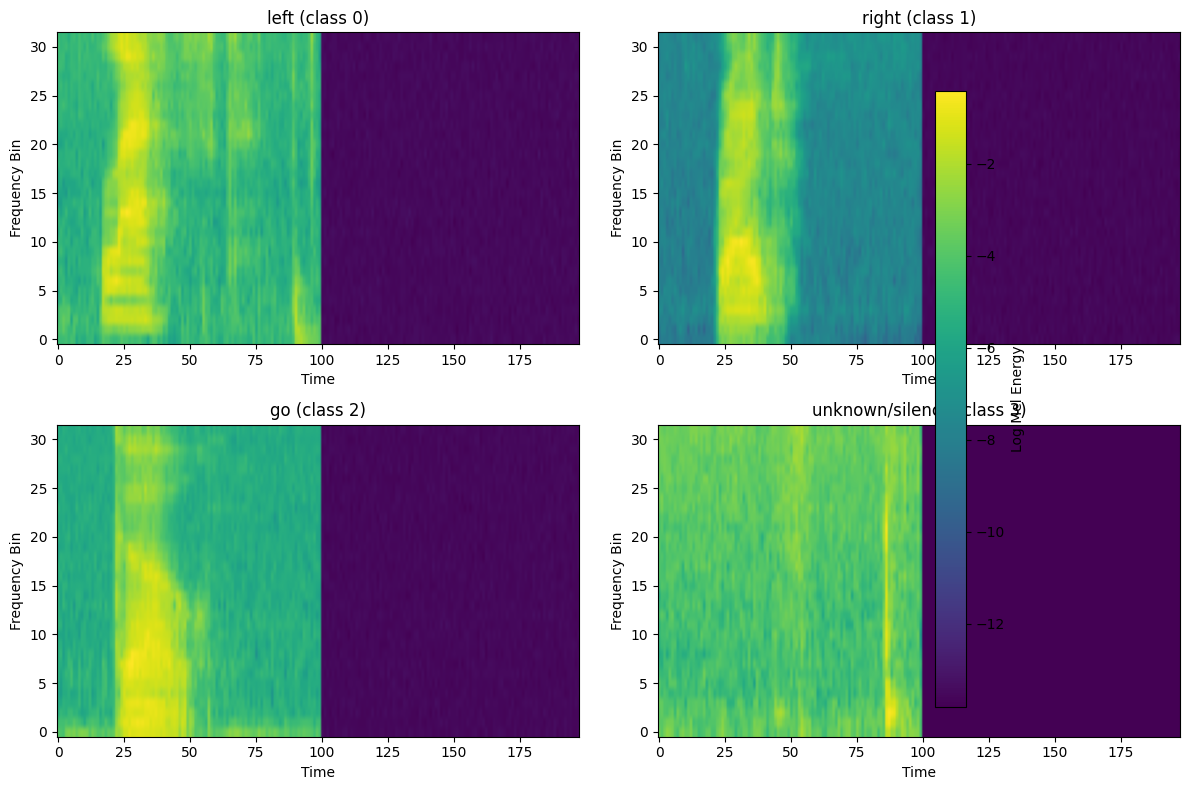


Spectrogram visualization saved to 'spectrogram_examples.png'


In [7]:
# Visualize spectrograms for each keyword
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

keyword_names = ['left', 'right', 'go', 'unknown/silence']
examples_found = {i: 0 for i in range(4)}
spectrograms_to_plot = {i: None for i in range(4)}

# Search for examples of each class
for spectrograms, labels in ds_train_processed.take(100):  # Increased from 50 to 100
    for i in range(len(labels)):
        label = int(labels[i].numpy())
        if label < 4 and examples_found[label] == 0:
            spectrograms_to_plot[label] = spectrograms[i].numpy()
            examples_found[label] = 1
            print(f"Found example for class {label} ({keyword_names[label]})")
    
    if all(examples_found.values()):
        print("\nAll classes found!")
        break

# Plot all spectrograms
for class_id in range(4):
    ax = axes[class_id]
    if spectrograms_to_plot[class_id] is not None:
        spectrogram = spectrograms_to_plot[class_id]
        im = ax.imshow(spectrogram.T, aspect='auto', origin='lower', cmap='viridis')
        ax.set_title(f'{keyword_names[class_id]} (class {class_id})')
        ax.set_xlabel('Time')
        ax.set_ylabel('Frequency Bin')
    else:
        ax.text(0.5, 0.5, f'No example found\nfor {keyword_names[class_id]}', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{keyword_names[class_id]} (class {class_id})')

plt.colorbar(im, ax=axes, label='Log Mel Energy')
plt.tight_layout()
plt.savefig('spectrogram_examples.png', dpi=150)
plt.show()

print("\nSpectrogram visualization saved to 'spectrogram_examples.png'")

## Step 6: Build CNN Model for Spectrogram Input

This model is based on the TFLite Micro tiny_conv architecture, optimized for spectrogram inputs.

In [8]:
def build_tiny_conv_model(input_shape=(SPECTROGRAM_LENGTH, FEATURE_BIN_COUNT), num_classes=4):
    """Build tiny_conv model similar to TFLite Micro micro_speech"""
    
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        
        # Expand dimensions for Conv2D
        tf.keras.layers.Reshape((input_shape[0], input_shape[1], 1)),
        
        # First conv block - larger filters to capture temporal-frequency patterns
        tf.keras.layers.Conv2D(8, (10, 8), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # Second conv block
        tf.keras.layers.Conv2D(16, (5, 4), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # Third conv block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # Flatten and classify
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Build the model
model = build_tiny_conv_model(num_classes=NUM_CLASSES)
model.summary()

# Print input/output shapes
print(f"\nModel expects input shape: {model.input_shape}")
print(f"Model output shape: {model.output_shape}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 198, 32, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 198, 32, 8)     │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 99, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 99, 16, 16)     │         2,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 49, 8, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 49, 8, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 49, 8, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 4, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 4, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       196,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,796 (799.98 KB)

 Trainable params: 204,796 (799.98 KB)

 Non-trainable params: 0 (0.00 B)


Model expects input shape: (None, 198, 32)
Model output shape: (None, 4)


## Step 7: Compile the Model

In [9]:
# Compile the model
initial_learning_rate = LEARNING_RATE

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")
print(f"Optimizer: Adam")
print(f"Learning rate: {initial_learning_rate}")
print(f"Loss: sparse_categorical_crossentropy")
print(f"\nNote: No class weights needed - dataset is already balanced!")

Model compiled successfully!
Optimizer: Adam
Learning rate: 0.001
Loss: sparse_categorical_crossentropy

Note: No class weights needed - dataset is already balanced!


## Step 8: Train the Model

Training parameters:
- **Epochs**: 30 (to ensure convergence with spectrogram features)
- **Batch size**: 64
- **Learning rate**: 0.001 with decay
- **Data augmentation**: Background noise (80% probability)

Expected outcome: validation accuracy above 90% for keyword spotting.

In [ ]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-6,
        verbose=1
    ),
    tf.keras.callbacks.TensorBoard(
        log_dir='logs',
        histogram_freq=1
    )
]

# Calculate steps per epoch
total_balanced = target_samples_per_class * NUM_CLASSES
steps_per_epoch = total_balanced // BATCH_SIZE

# Train the model
print("Starting training...")
print(f"Total epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training samples per epoch: {total_balanced:,} (balanced)")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation samples: ~10,000 (unbalanced - real-world distribution)\n")

history = model.fit(
    ds_train_processed,
    steps_per_epoch=steps_per_epoch,  # CRITICAL: specify steps since dataset repeats
    validation_data=ds_val_processed,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining complete!")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")

Starting training...
Total epochs: 30
Batch size: 64
Training samples per epoch: 4,396 (balanced)
Steps per epoch: 68
Validation samples: ~10,000 (unbalanced - real-world distribution)

Epoch 1/30


2025-11-10 23:01:01.356623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:329: Filling up shuffle buffer (this may take a while): 1930 of 2000
2025-11-10 23:01:01.620660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.
2025-11-10 23:01:01.976865: I external/local_xla/xla/service/service.cc:163] XLA service 0x7a6430031db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-10 23:01:01.976917: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2025-11-10 23:01:02.089284: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-10 23:01:02.485804: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91500


 1/68 ━━━━━━━━━━━━━━━━━━━━ 17:40 16s/step - accuracy: 0.2656 - loss: 6.3478

I0000 00:00:1762812066.220652  255010 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.3724 - loss: 2.5144
Epoch 1: val_accuracy improved from None to 0.89240, saving model to best_model.keras


2025-11-10 23:01:22.116478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:329: Filling up shuffle buffer (this may take a while): 1550 of 2000


68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 246ms/step - accuracy: 0.3369 - loss: 1.7103 - val_accuracy: 0.8924 - val_loss: 1.2679 - learning_rate: 0.0010
Epoch 2/30


2025-11-10 23:01:24.344632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.
2025-11-10 23:01:24.663052: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-10 23:01:26.392638: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2036', 96 bytes spill stores, 96 bytes spill loads

2025-11-10 23:01:26.620303: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2036', 520 bytes spill stores, 520 bytes spill loads



68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.1459 - loss: 1.4225
Epoch 2: val_accuracy did not improve from 0.89240
68/68 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 0.2059 - loss: 1.3993 - val_accuracy: 0.8919 - val_loss: 1.3649 - learning_rate: 0.0010
Epoch 3/30
 1/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3750 - loss: 1.3753

2025-11-10 23:01:44.683131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:329: Filling up shuffle buffer (this may take a while): 1627 of 2000
2025-11-10 23:01:46.363315: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.1848 - loss: 1.3872
Epoch 3: val_accuracy did not improve from 0.89240
68/68 ━━━━━━━━━━━━━━━━━━━━ 18s 265ms/step - accuracy: 0.2442 - loss: 1.3745 - val_accuracy: 0.3448 - val_loss: 1.2829 - learning_rate: 0.0010
Epoch 4/30
 1/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4531 - loss: 1.2512

2025-11-10 23:02:02.298040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:329: Filling up shuffle buffer (this may take a while): 1689 of 2000
2025-11-10 23:02:03.730026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


66/68 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.3027 - loss: 1.3833
Epoch 4: val_accuracy did not improve from 0.89240
68/68 ━━━━━━━━━━━━━━━━━━━━ 18s 261ms/step - accuracy: 0.3176 - loss: 1.3548 - val_accuracy: 0.5961 - val_loss: 1.2280 - learning_rate: 0.0010
Epoch 5/30
 1/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3750 - loss: 1.3246

2025-11-10 23:02:19.588574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:329: Filling up shuffle buffer (this may take a while): 1489 of 2000
2025-11-10 23:02:21.856690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


 5/68 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - accuracy: 0.3853 - loss: 1.3160

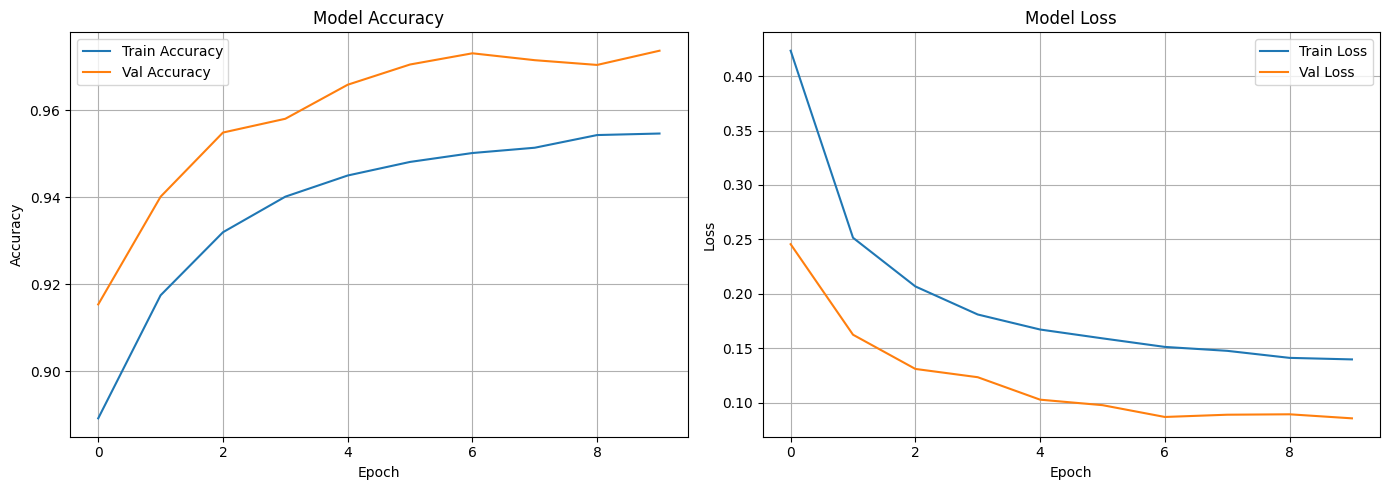


Final Training Accuracy: 0.9546
Final Validation Accuracy: 0.9737


In [ ]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy')
ax1.legend()
ax1.grid(True)

# Loss plot
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Model Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

# Print final results
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

## Step 9: Evaluate on Test Set

In [ ]:
# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_accuracy = model.evaluate(ds_test_processed, verbose=1)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Evaluating on test set...
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9256 - loss: 0.1867

Test Accuracy: 0.9256
Test Loss: 0.1867


## Step 10: Export TensorFlow Lite Models

We'll export both:
1. **Float32 model** - Full precision model
2. **INT8 quantized model** - Required for Edge TPU deployment

In [ ]:
import os
import numpy as np

# Create models directory
os.makedirs('trained_models', exist_ok=True)

print("=" * 60)
print("Saving Model and Calibration Data")
print("=" * 60)

# Step 1: Save the trained model
print("\n1. Saving Keras model...")
model_path = 'trained_models/model.keras'
model.save(model_path)
print(f"   ✓ Saved: {model_path}")

# Step 2: Save calibration data for INT8 quantization
print("\n2. Collecting calibration data...")
calibration_samples = []
for i, (spectrograms, _) in enumerate(ds_train_processed.take(50)):
    calibration_samples.append(spectrograms[0].numpy())
    if i % 10 == 0:
        print(f"   Collecting batch {i}/50...")

calibration_data = np.array(calibration_samples)
calibration_path = 'trained_models/calibration_data.npy'
np.save(calibration_path, calibration_data)
print(f"   ✓ Saved {len(calibration_data)} samples to: {calibration_path}")

print("\n" + "=" * 60)
print("✓ Model and calibration data saved!")
print("=" * 60)
print("\nYou can now restart the kernel and run the next cell")
print("to convert to TFLite without retraining.")

Saving Model and Calibration Data

1. Saving Keras model...
   ✓ Saved: trained_models/model.keras

2. Collecting calibration data...
   ✓ Saved 50 samples to: trained_models/calibration_data.npy

✓ Model and calibration data saved!

You can now restart the kernel and run the next cell
to convert to TFLite without retraining.


2025-11-10 22:10:47.775856: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
import os
import tensorflow as tf
import numpy as np

# Paths
model_path = 'trained_models/model.keras'
calibration_path = 'trained_models/calibration_data.npy'
float_output = 'trained_models/model.tflite'
int8_output = 'trained_models/model_int8.tflite'

print("=" * 60)
print("TFLite Model Conversion")
print("=" * 60)
print(f"TensorFlow version: {tf.__version__}")

# Check if files exist
if not os.path.exists(model_path):
    print(f"\n✗ Error: Model not found at {model_path}")
    print("Please run the previous cell to save the model first.")
else:
    print(f"\n✓ Found model: {model_path}")

if not os.path.exists(calibration_path):
    print(f"✗ Error: Calibration data not found at {calibration_path}")
else:
    print(f"✓ Found calibration data: {calibration_path}")

# Load model
print("\nLoading model...")
loaded_model = tf.keras.models.load_model(model_path)
print("✓ Model loaded")
print(f"Model input shape: {loaded_model.input_shape}")
print(f"Model output shape: {loaded_model.output_shape}")

# Load calibration data
calibration_data = np.load(calibration_path)
print(f"\nLoaded {len(calibration_data)} calibration samples")

# Create concrete function with fixed batch size
run_model = tf.function(lambda x: loaded_model(x))
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(shape=[1, 198, 32], dtype=tf.float32)
)

# ============================================================
# Step 1: Float32 TFLite with fixed input shape
# ============================================================
print("\n" + "=" * 60)
print("1. Converting to Float32 TFLite")
print("=" * 60)

converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
tflite_model = converter.convert()

with open(float_output, 'wb') as f:
    f.write(tflite_model)

float_size = os.path.getsize(float_output) / 1024
print(f"✓ Float32 model saved: {float_output}")
print(f"✓ Size: {float_size:.2f} KB")

# ============================================================
# Step 2: Full INT8 TFLite (TFLite Micro compatible)
# ============================================================
print("\n" + "=" * 60)
print("2. Converting to Full INT8 TFLite")
print("=" * 60)

# Representative dataset generator
def representative_dataset_gen():
    for i in range(len(calibration_data)):
        if i % 10 == 0:
            print(f"  Processing sample {i}/{len(calibration_data)}")
        sample = np.expand_dims(calibration_data[i], axis=0).astype(np.float32)
        yield [sample]

print("\nConverting with full INT8 quantization (TFLite Micro compatible)...")
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen

# CRITICAL: Set input/output types to INT8 for TFLite Micro compatibility
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

try:
    tflite_quant_model = converter.convert()
    
    with open(int8_output, 'wb') as f:
        f.write(tflite_quant_model)
    
    int8_size = os.path.getsize(int8_output) / 1024
    compression = (1 - int8_size / float_size) * 100
    
    print(f"\n✓ Full INT8 model saved: {int8_output}")
    print(f"✓ Size: {int8_size:.2f} KB")
    print(f"✓ Compression: {compression:.1f}% reduction")
    print(f"✓ TFLite Micro compatible (no QUANTIZE/DEQUANTIZE ops)")
    
    print("\n" + "=" * 60)
    print("Next Steps:")
    print("=" * 60)
    print("\n1. Compile with Edge TPU Compiler:")
    print(f"   edgetpu_compiler {int8_output}")
    print("\n2. Copy compiled model:")
    print("   cp model_int8_edgetpu.tflite models/")
    print("\n3. Rebuild and flash:")
    print("   bash build.sh")
    print("   python3 scripts/flashtool.py --build_dir build \\")
    print("     --elf_path build/examples/classify_keywords/classify_keywords")
    
except Exception as e:
    print(f"\n✗ Full INT8 conversion failed: {type(e).__name__}")
    print(f"Error: {str(e)[:300]}")
    print("\nThis may be due to TensorFlow version compatibility.")
    print("Try using the Float32 model and let Edge TPU Compiler quantize it:")
    print(f"  edgetpu_compiler {float_output}")

print("\n" + "=" * 60)

TFLite Model Conversion
TensorFlow version: 2.20.0

✓ Found model: trained_models/model.keras
✓ Found calibration data: trained_models/calibration_data.npy

Loading model...
✓ Model loaded
Model input shape: (None, 198, 32)
Model output shape: (None, 5)

Loaded 50 calibration samples

1. Converting to Float32 TFLite


I0000 00:00:1762809281.673114  219143 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1762809281.673201  219143 single_machine.cc:376] Starting new session
I0000 00:00:1762809281.679843  219143 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5994 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
W0000 00:00:1762809281.726801  219143 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1762809281.726822  219143 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-11-10 22:14:41.763088: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:4150] Estimated count of arithmetic ops: 20.404 M  ops, equivalently 10.202 M  MACs
I0000 00:00:1762809281.779778  219143 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1762809281.779901  219143 single_machine.cc:3

✓ Float32 model saved: trained_models/model.tflite
✓ Size: 803.91 KB

2. Converting to Full INT8 TFLite

Converting with full INT8 quantization (TFLite Micro compatible)...
  Processing sample 0/50
  Processing sample 10/50
  Processing sample 20/50
  Processing sample 30/50
  Processing sample 40/50

✓ Full INT8 model saved: trained_models/model_int8.tflite
✓ Size: 207.68 KB
✓ Compression: 74.2% reduction
✓ TFLite Micro compatible (no QUANTIZE/DEQUANTIZE ops)

Next Steps:

1. Compile with Edge TPU Compiler:
   edgetpu_compiler trained_models/model_int8.tflite

2. Copy compiled model:
   cp model_int8_edgetpu.tflite models/

3. Rebuild and flash:
   bash build.sh
   python3 scripts/flashtool.py --build_dir build \
     --elf_path build/examples/classify_keywords/classify_keywords



## Checkpoint Questions (from Tutorial)

1. **What final accuracy did your model achieve?**
   - Check the test accuracy above

2. **Compare file sizes of float vs INT8 TFLite models.**
   - See the size comparison above

3. **Why is INT8 quantization required for Coral Edge TPU?**
   - Edge TPU is optimized for INT8 operations, providing faster inference with lower power consumption
   - INT8 models are much smaller, fitting better in limited memory
   - The hardware accelerator only supports quantized operations

4. **How do the left, right, and go commands map to robot motion?**
   - left (0): Turn robot left
   - right (1): Turn robot right  
   - go (2): Move robot forward

## Summary

You have successfully:
- ✅ Downloaded the Speech Commands dataset
- ✅ Configured for three keywords (left, right, go)
- ✅ Built and trained a CNN keyword spotting model
- ✅ Exported both Float32 and INT8 TFLite models
- ✅ Documented training results

**Next Steps:**
1. Compile the INT8 model for Edge TPU
2. Deploy to Coral Dev Board Micro
3. Integrate with MATLAB simulation (Task 3)
4. Conduct Hardware-in-the-Loop testing (Task 4)